In [2]:
import pandas as pd
import numpy as np

# utility
from sklearn.base import clone
from sklearn.pipeline import make_pipeline

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# feature selection / preprocessing
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from augmentdatalib_source.knnor.data_augment import KNNOR
from mlxtend.feature_selection import SequentialFeatureSelector

# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, ComplementNB
from lineartree import LinearTreeClassifier
from xgboost import XGBClassifier, DMatrix
from catboost import CatBoostClassifier

# analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None) # show all cols

In [3]:
def weight_to_int(row):
    try:
        return int(row)
    except:
        return int(row.split(" ")[0])


def height_to_inches(row):
    if type(row) == float:
        # 6.10 -> 72 inches
        feet, inches = str(row).split(".")
        return int(feet) * 12 + int(inches)

    if type(row) == str:
        # 6' 10" -> 72 inches
        feet, inches = str(row).split(" ")
        feet = feet.replace("'", '')
        inches = inches.replace('"', '')
        return int(feet) * 12 + int(inches)

    if type(row) == int:
        return row * 12


players_df = pd.read_excel("Brdi_db_march.xlsx", engine="openpyxl").drop(columns=[123, "id", "Data Initials", "Code Name", "draft status", ])

# if no prev concussions "# of concussions" = 0
players_df.loc[players_df["previous concussions?"] == "NO", '# of concussions'] = 0

# "previous concussions?" YES/NO -> 0/1
players_df["previous concussions?"] = players_df["previous concussions?"].apply(lambda x: 1 if x=="YES" else 0)

# weight -> int
players_df["weight"] = players_df["weight"].apply(weight_to_int)

# height -> inches as int
players_df["height"] = players_df["height"].apply(height_to_inches)

# draft year -> int *not drafted == -1*
players_df["draft year"] = players_df["draft year"].apply(lambda x: int(x) if pd.notnull(x) and x != 0 else -1)

# draft number -> int *not drafted == -1*
players_df["draft number"] = players_df["draft number"].apply(lambda x: int(x) if pd.notnull(x) and x != 0 else -1)

# create drafted row
players_df["drafted"] = players_df["draft number"].apply(lambda x: 0 if x == -1 else 1)
column_to_move = players_df.pop("drafted")
players_df.insert(8, "drafted", column_to_move)

players_df.to_excel("Brdi_db_clean.xlsx")
players_df.head(123)

,year,DOB,age as of June 1,height,weight,NHL,draft year,draft number,drafted,shoots,Position,previous concussions?,# of concussions,bimanual score: washer,Bimanual Score: Button,DR Errors: V,DR Errors: HR,RT_V,RT_HR,Delta_RT,MT_V,MT_HR,Delta_MT,TMT_V,TMT_HR,CMT: V,CMT: HR,cvRT_V,cvRT_HR,stdRT_V,stdRT_HR,Ball Path_V,Ball Path_HR,Delta_BallPath,FullPath_V,FullPath_HR,Delta_Fullpath,Corrective_V,Corrective_HR,PeakV_V,PeakV_HR,Delta_PV,AE_V,AE_HR,Delta_AE,VE_V,VE_HR,Delta: VE,AbsOnAxis_V,AbsOnAxis_HR,Delta_OnAxis,AbsOffAxis_V,AbsOffAxis_HR,Delta_OffAxis
0,2012,1993-10-22,18,73,193,0,2012,174,1,L,F,1,1.0,20.54,NaN,NaN,NaN,426.570000,680.8300,254.26,241.7300,895.6200,653.90,285.4000,1200.6900,43.67,305.07,0.100000,0.210000,42.79000,140.47000,64.82,66.62,1.80,70.00,77.51,7.50,5.18,10.89,211.8900,64.6800,-147.21,9.7100,15.4400,5.73,5.0200,8.7700,NaN,8.01000,10.940000,2.92,3.790000,7.560000,3.77
1,2012,1994-03-04,18,73,180,0,2012,82,1,L,F,1,NaN,19.00,NaN,NaN,NaN,432.096614,587.0299,154.93,201.9240,331.0767,129.15,235.6560,637.0870,33.73,306.01,0.100000,0.090000,42.13000,55.27000,59.15,64.11,4.96,65.77,74.54,8.77,6.61,10.42,245.8500,178.1700,-67.68,12.3700,14.6200,2.24,9.3700,8.5000,NaN,10.69000,9.630000,-1.06,2.040000,5.690000,3.66
2,2012,1994-03-11,18,73,196,0,2012,194,1,L,F,1,1.0,20.20,NaN,NaN,NaN,398.272727,541.1175,142.84,259.1539,222.6922,-36.46,265.3636,249.5000,6.21,26.81,0.090000,0.280000,34.58000,151.09000,69.48,62.36,-7.12,69.73,73.17,3.44,0.25,10.81,195.6900,238.3500,42.66,5.2200,6.0700,0.84,4.1300,0.8300,NaN,3.11000,11.610000,8.50,1.940000,0.790000,-1.15
3,2012,1994-01-03,18,71,178,0,2012,180,1,L,F,1,1.0,17.20,NaN,NaN,NaN,663.000000,1279.9670,616.97,311.8333,578.4696,266.64,371.2000,912.7325,59.37,334.26,0.920000,0.820000,609.51000,1051.09000,69.52,64.02,-5.50,69.52,79.74,10.22,0.00,15.72,457.9600,128.8100,-329.16,3.9600,12.6200,8.66,0.9400,5.2200,NaN,3.14000,13.250000,10.11,1.580000,8.260000,6.67
4,2012,1994-01-22,18,75,202,0,2012,40,1,R,D,1,1.0,24.00,NaN,NaN,NaN,490.080000,767.1300,277.06,204.8800,300.9600,96.07,208.7100,760.9400,3.83,459.98,0.080000,0.120000,38.93000,92.45000,66.88,65.63,-1.25,69.12,81.85,12.73,2.24,16.22,250.6800,195.3700,-55.30,8.9900,13.4200,4.42,2.3500,8.9200,NaN,7.44721,8.597285,1.15,1.791101,6.231146,4.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2014,1995-10-24,18,71,180,1,2014,19,1,R,D,0,0.0,28.16,16.59,NaN,1.0,394.333523,564.9610,170.63,219.4186,307.9426,88.52,264.7517,795.7188,45.33,487.78,0.079466,0.155812,31.33609,88.02793,68.56,60.64,-7.92,73.86,74.72,0.86,5.30,14.08,264.3481,181.3646,-82.98,8.9438,13.5755,4.63,9.8023,9.8900,0.09,4.19970,11.500800,7.30,1.998500,2.271900,0.27
119,2014,1996-01-22,18,72,173,1,2014,28,1,R,F,0,0.0,23.73,13.25,NaN,1.0,503.523240,615.5299,112.01,367.6700,243.2263,-124.44,440.0524,424.0147,72.38,180.79,0.368532,0.330843,185.56450,203.64400,66.37,67.83,1.46,70.30,68.69,-1.61,3.93,0.86,176.2499,199.9319,23.68,9.5019,11.2735,1.77,5.2539,3.4089,-1.84,8.32080,9.869900,1.55,1.998500,3.648200,1.65
120,2014,1996-02-15,18,74,200,1,2014,41,1,R,D,0,0.0,20.40,14.22,NaN,0.0,468.076923,651.6511,183.57,385.9464,388.2311,2.28,409.2898,418.9641,23.34,30.73,0.127080,0.196829,59.48314,128.26380,64.06,72.65,8.59,70.01,72.00,1.98,5.95,-0.65,162.1795,169.4676,7.29,9.8984,7.4700,-2.43,4.9097,5.5820,0.67,9.29020,2.385000,-6.91,0.565600,3.591600,3.03
121,2014,1996-08-12,17,74,194,1,2014,42,1,L,F,0,0.0,21.29,13.12,NaN,0.0,379.600000,539.6085,160.01,234.0372,255.1963,21.16,280.5859,618.5576,46.55,363.36,0.106403,0.119280,40.39059,64.36458,69.64,59.83,-9.81,72.07,72.40,0.32,2.44,12.57,250.5720,186.2882,-64.28,6.0175,15.5713,9.55,5.7879,4.6840,-1.10,2.62540,13.951700,11.33,1.838200,3.110900,1.27


In [4]:
players_df.describe()

,year,age as of June 1,height,weight,NHL,draft year,draft number,drafted,previous concussions?,# of concussions,bimanual score: washer,Bimanual Score: Button,DR Errors: V,DR Errors: HR,RT_V,RT_HR,Delta_RT,MT_V,MT_HR,Delta_MT,TMT_V,TMT_HR,CMT: V,CMT: HR,cvRT_V,cvRT_HR,stdRT_V,stdRT_HR,Ball Path_V,Ball Path_HR,Delta_BallPath,FullPath_V,FullPath_HR,Delta_Fullpath,Corrective_V,Corrective_HR,PeakV_V,PeakV_HR,Delta_PV,AE_V,AE_HR,Delta_AE,VE_V,VE_HR,Delta: VE,AbsOnAxis_V,AbsOnAxis_HR,Delta_OnAxis,AbsOffAxis_V,AbsOffAxis_HR,Delta_OffAxis
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,121.000000,123.000000,84.000000,1.0,60.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,121.000000,120.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,99.000000,121.000000,120.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,84.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,2013.170732,17.853659,73.430894,199.097561,0.601626,1931.300813,63.154472,0.959350,0.479675,0.578512,21.270325,13.022619,1.0,1.016667,434.180646,593.904609,159.724390,277.579482,463.583629,186.004390,318.534559,722.910448,35.775610,241.694878,0.208194,0.191472,107.555184,119.001716,66.390976,64.134712,-1.613737,69.826237,75.326171,4.797236,2.300407,9.353902,228.392658,166.043516,-62.349512,9.285762,14.896609,5.610813,6.231909,7.408579,1.657381,7.598168,13.061285,5.463902,2.250014,4.469445,2.219187
std,0.884357,0.418485,2.080673,13.160058,0.491566,399.385592,55.685450,0.198287,0.501630,0.680099,3.037066,2.673699,NaN,1.157022,80.210850,121.934666,115.687857,96.923911,278.092107,241.906362,100.883039,363.248060,57.160833,191.723119,0.275380,0.096755,203.363736,102.968214,4.267592,8.062642,7.343458,3.412067,8.933885,14.327904,8.340000,12.100326,72.256045,68.344871,59.025185,4.667579,7.102918,6.463210,3.369061,3.765822,4.747954,6.035495,7.639019,7.116158,1.060894,2.235848,2.317407
min,2012.000000,17.000000,61.000000,166.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,2.950000,8.300000,1.0,0.000000,340.120000,412.800000,-306.850000,117.800000,163.450000,-500.150000,183.960000,161.460000,-313.250000,-297.050000,0.050000,0.040000,18.469570,25.220000,51.180000,37.280000,-24.030000,60.930000,56.790000,-70.010000,-56.710000,-57.030000,111.710000,48.253000,-346.370000,3.384900,2.000000,-11.960000,0.000000,0.000000,-9.550000,1.980000,2.385000,-10.540000,0.565600,0.790000,-1.520000
25%,2012.000000,18.000000,72.000000,191.000000,0.000000,2012.000000,22.500000,1.000000,0.000000,0.000000,19.625000,11.400000,1.0,0.000000,386.081666,518.690200,111.695000,212.280000,255.208150,33.225000,252.590000,496.694300,9.635000,129.155000,0.089164,0.140000,34.578725,74.976645,64.200000,60.645000,-5.880000,68.130000,70.455000,0.870000,0.730000,5.105000,179.970000,121.390000,-90.250000,6.696200,11.092600,2.060000,3.850950,5.065000,-1.135000,4.347602,8.540743,1.170000,1.475000,2.800000,0.540000
50%,2013.000000,18.000000,74.000000,200.000000,1.000000,2013.000000,43.000000,1.000000,0.000000,0.000000,21.080000,12.715000,1.0,1.000000,417.510000,577.053400,155.900000,255.830000,368.026400,122.660000,298.264900,671.060400,29.530000,220.460000,0.110000,0.170000,43.295720,95.775820,66.880000,64.870000,-1.300000,69.520000,73.515000,3.940000,2.240000,9.740000,217.350000,161.799500,-57.690000,8.290000,13.560000,4.800000,5.450000,7.950000,1.560000,6.490000,11.220000,4.200000,2.022100,4.095965,1.820000
75%,2014.000000,18.000000,74.500000,206.500000,1.000000,2014.000000,86.500000,1.000000,1.000000,1.000000,23.000000,14.090000,1.0,2.000000,457.315000,641.015000,208.565000,312.806650,572.269650,270.060000,351.380000,877.145000,52.960000,333.940000,0.175000,0.225864,74.505595,134.970000,68.975000,67.870000,2.500000,70.420000,77.942500,8.045000,4.655000,14.185000,254.050000,203.031550,-3

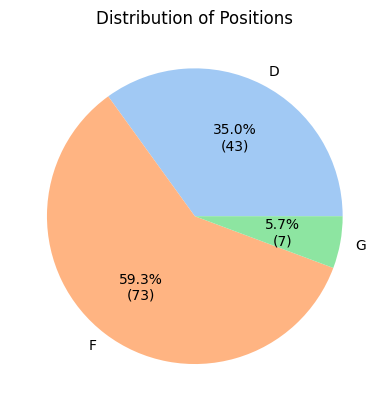

In [5]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

positions = players_df.groupby("Position").year.count()
colors = sns.color_palette('pastel')[0:5]

plt.title(label="Distribution of Positions")
plt.pie(positions, labels = positions.index, colors = colors, autopct=autopct_format(positions))
plt.show()

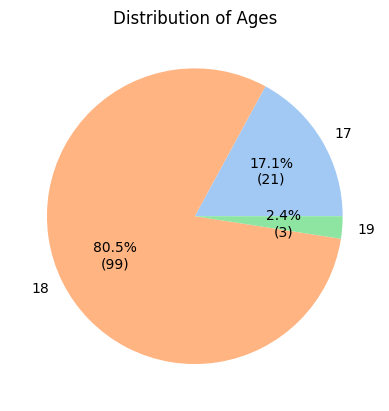

In [6]:
ages = players_df.groupby("age as of June 1").year.count()
colors = sns.color_palette('pastel')[0:5]

plt.title(label="Distribution of Ages")
plt.pie(ages, labels = ages.index, colors = colors, autopct=autopct_format(ages))
plt.show()

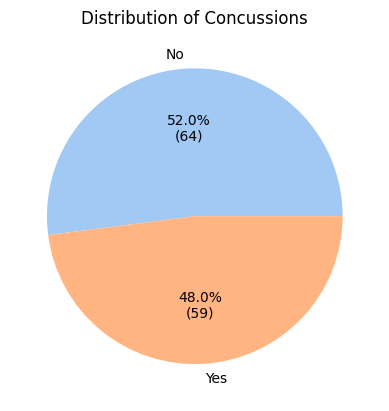

In [7]:
concussions = players_df.groupby("previous concussions?").year.count()
colors = sns.color_palette('pastel')[0:5]

plt.title(label="Distribution of Concussions")
plt.pie(concussions, labels = ["No", "Yes"], colors = colors, autopct=autopct_format(concussions))
plt.show()

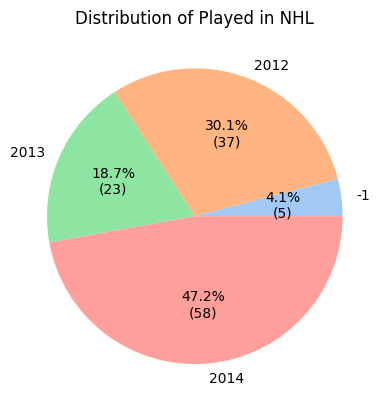

In [8]:
drafted = players_df.groupby("draft year").year.count()
colors = sns.color_palette('pastel')[0:5]

plt.title(label="Distribution of Played in NHL")
plt.pie(drafted, labels = drafted.index, colors = colors, autopct=autopct_format(drafted))
plt.show()

In [9]:
def seaborn_conf_matrix(cm):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

## Weighted SVM for Draft Classification

### Types of scaling

standard: $\frac{x_k(d) - \mu_k}{ \sigma_k}$

In [10]:
def print_metrics(y_test, y_pred):
    otuput = f"""precision: {precision_score(y_test, y_pred)}\nrecall: {recall_score(y_test, y_pred)}\naccuracy: {accuracy_score(y_test, y_pred)}\nf1: {f1_score(y_test, y_pred)}"""
    print(otuput)


In [11]:

def print_all_metrics(y_test, yhat, classifier=True):
    print(f'\n\n-----MODULE {"CLASSIFICATION" if classifier else "PREDICTION"} METRICS-----')
    if classifier:    
        print_metrics(y_test, yhat)
        seaborn_conf_matrix(confusion_matrix(y_test, yhat))

In [12]:
def create_dataset(df, target_col="NHL"):

    non_feature_cols = ["year","DOB", "draft year", "shoots", "Position", "drafted", "draft number"]


    # X_train, X_test, y_train, y_test = scale_and_split(df, scaler="None", test_size=.3, target_col="NHL")
    # scale X train
    y = df[target_col]
    X = df.drop(columns=non_feature_cols + [target_col])

    X = X.fillna(X.mean())


    return X,y

In [61]:
def scale_and_split(df, scaler="standard", target_col="drafted", test_size=0.2, shuffle=False, print_columns=False, return_feature_names=False):
    non_feature_cols = ["year","DOB", "draft year", "shoots", "Position"]

    # if target == "drafted":
    #     df.drop(df.loc[df['line_race']==0].index, inplace=True)
    #     target = df[target_col]
    #     features = df.drop(columns=non_feature_cols + [target_col])
        
    X, y = create_dataset(df, target_col=target_col)
    feature_names = X.columns
    if print_columns:
        print(X.columns)
        
   

    if scaler == "standard":
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # shuffler = np.random.permutation(len(X))
    # X = X[shuffler]
    # y = y[shuffler]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=np.random.randint(25) if shuffle else 50)
         
    if not return_feature_names:
        return  X_train, X_test, y_train, y_test
    else:
       return  X_train, X_test, y_train, y_test, feature_names


    

In [14]:
feature_cols = ['age as of June 1', 'height', 'weight', 'NHL',
       'previous concussions?', '# of concussions', 'bimanual score: washer',
       'Bimanual Score: Button', 'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'MT_HR',
       'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT: V', 'CMT: HR', 'cvRT_V', 'cvRT_HR',
       'stdRT_V', 'stdRT_HR', 'Ball Path_V', 'Ball Path_HR', 'Delta_BallPath',
       'FullPath_V', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V',
       'Corrective_HR', 'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR',
       'Delta_AE', 'VE_V', 'VE_HR', 'Delta: VE', 'AbsOnAxis_V', 'AbsOnAxis_HR',
       'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR', 'Delta_OffAxis']

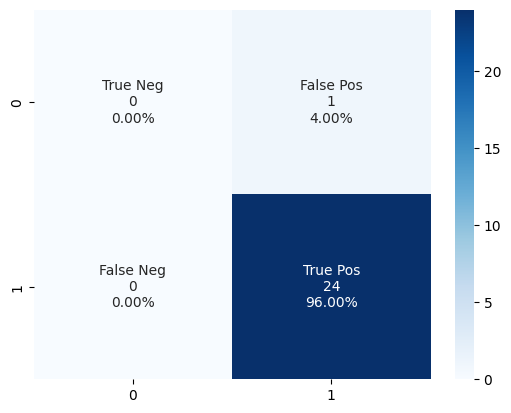

In [15]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, "standard", test_size=.2)

model = SVC(gamma='auto')
model.fit(X_train, y_train)
yhat = model.predict(X_test)


seaborn_conf_matrix(confusion_matrix(y_test, yhat))





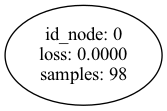

precision: 0.9583333333333334
recall: 0.9583333333333334
accuracy: 0.92
f1: 0.9583333333333334


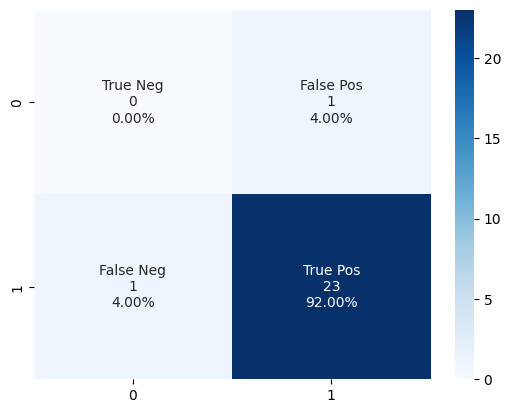

In [16]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
X_train, X_test, y_train, y_test = scale_and_split(players_df, "standard", test_size=.2)
model = LinearTreeClassifier(base_estimator=LogisticRegression())

model.fit(X_train, y_train)
display(model.plot_model(feature_names=feature_cols))
yhat = model.predict(X_test)

seaborn_conf_matrix(confusion_matrix(y_test, yhat))
print_metrics(y_test, yhat)

precision: 0.9565217391304348
recall: 0.9166666666666666
accuracy: 0.88
f1: 0.9361702127659574
[1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


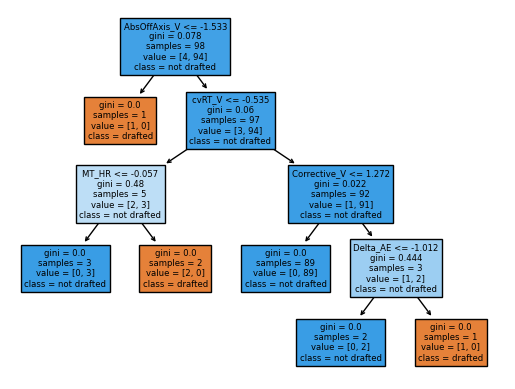

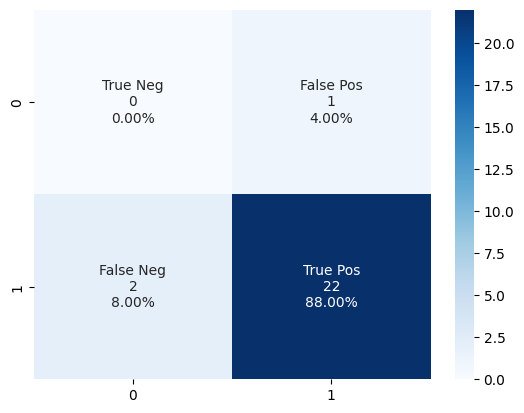

In [17]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

X_train, X_test, y_train, y_test = scale_and_split(players_df, "standard", test_size=.2)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

tree.plot_tree(clf, 
                   feature_names=feature_cols,  
                   class_names=["drafted", "not drafted"],
                   filled=True)

print_metrics(y_test, yhat)
print(yhat)
print(list(y_test))
plt.show()
seaborn_conf_matrix(confusion_matrix(y_test, yhat))

_____

In [18]:
class GeneralClassifier:
    def __init__(self, base_classifier=LogisticRegression(), data=None, target="NHL") -> None:
        self.df = data
        self.target = target
        self.features = []

        self.model = base_classifier
    
        self.X_train, self.X_test, self.y_train, self.y_test = [],[],[],[],
        self.y_pred = []

        self.accuracy_metrics = {"precision" : 0, "recall" : 0, "f1" : 0, "accuracy" : 0 }

    def train_test_split(self, scaler="standard", test_size=0.2, shuffle=False):
            non_feature_cols = ["year","DOB", "draft year", "shoots", "Position"]

            # if target == "drafted":
            #     df.drop(df.loc[df['line_race']==0].index, inplace=True)
            #     target = df[target_col]
            #     features = df.drop(columns=non_feature_cols + [target_col])
                

            target_col=self.target

            y = self.df[target_col]
            
            if target_col == "drafted":
                X = self.df.drop(columns=non_feature_cols + [target_col] + ["draft number", "# of concussions", "previous concussions?"])
            else:
                X = self.df.drop(columns=non_feature_cols + [target_col])

            self.features = X.columns
            X = X.fillna(X.mean())

            if scaler == "standard":
                scaler = StandardScaler()
            
            # shuffler = np.random.permutation(len(X))
            # X = X[shuffler]
            # y = y[shuffler]

            X = scaler.fit_transform(X)

            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=np.random.randint(25) if shuffle else 50)

            return self

    def fit(self):
        self.model.fit(self.X_train, self.y_train)
        return self

    def predict(self,):
        self.y_pred = self.model.predict(self.X_test)
        return self

    def get_accuracy_metrics(self):
        self.accuracy_metrics["precision"] = precision_score(self.y_test, self.y_pred)
        self.accuracy_metrics["recall"] = recall_score(self.y_test, self.y_pred)
        self.accuracy_metrics["f1"] = f1_score(self.y_test, self.y_pred)
        self.accuracy_metrics["accuracy"] = accuracy_score(self.y_test, self.y_pred)

        return self

    def accuracy_heatmap(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
        plt.show()
        return self

    def display_metrics(self):
        output = f"""----- Classifier: {type(self.model).__name__}-----\n  * precision: {self.accuracy_metrics["precision"]}\n  * recall: {self.accuracy_metrics["recall"]}\n  * f1: {self.accuracy_metrics["f1"]}\n  * accuracy: {self.accuracy_metrics["accuracy"]}"""
        print(output)

        



### 1. Can categorize athletes who actually played on field based on their performance metrics: Binary Classification where the target is to predict if played NHL or not (column J) using performance metrics as input

### Class distributions

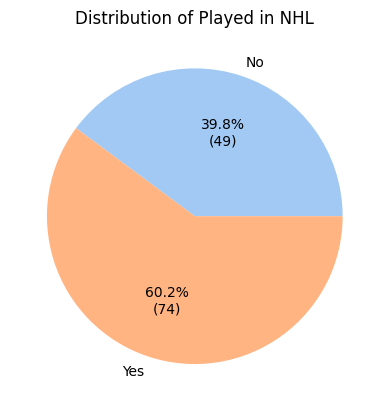

In [19]:
played_in_nhl = players_df.groupby("NHL").year.count()
colors = sns.color_palette('pastel')[0:5]

plt.title(label="Distribution of Played in NHL")
plt.pie(played_in_nhl, labels = ["No", "Yes"], colors = colors, autopct=autopct_format(played_in_nhl))
plt.show()

### Baseline Classifiers

In [20]:
clf = GeneralClassifier(base_classifier=LogisticRegression(), data=players_df, target="NHL")
clf = clf.train_test_split().fit().predict().get_accuracy_metrics()

clf.display_metrics()

----- Classifier: LogisticRegression-----
  * precision: 0.7647058823529411
  * recall: 0.8666666666666667
  * f1: 0.8125
  * accuracy: 0.76




-----MODULE CLASSIFICATION METRICS-----
precision: 0.7647058823529411
recall: 0.8666666666666667
accuracy: 0.76
f1: 0.8125


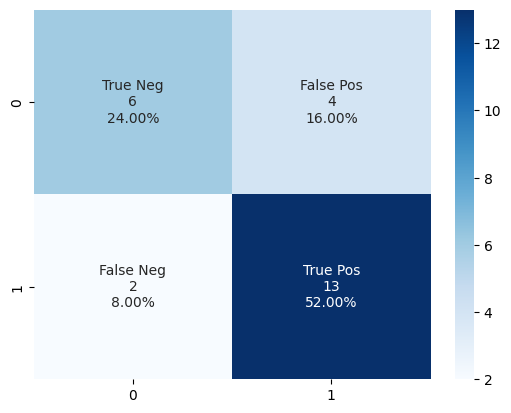

In [21]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="standard", test_size=.2, target_col="NHL")
model = LogisticRegression()

model.fit(X_train, y_train)
yhat = model.predict(X_test)


print_all_metrics(y_test, yhat, classifier=True)



-----MODULE CLASSIFICATION METRICS-----
precision: 0.7647058823529411
recall: 0.8666666666666667
accuracy: 0.76
f1: 0.8125


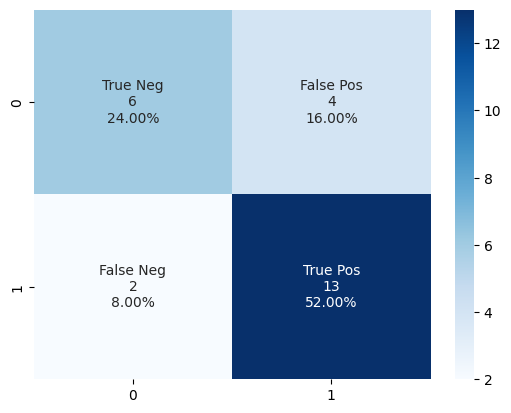

In [22]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="standard", test_size=.2, target_col="NHL")
model = DecisionTreeClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)


print_all_metrics(y_test, yhat, classifier=True)



-----MODULE CLASSIFICATION METRICS-----
precision: 0.6666666666666666
recall: 0.5333333333333333
accuracy: 0.56
f1: 0.5925925925925926


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


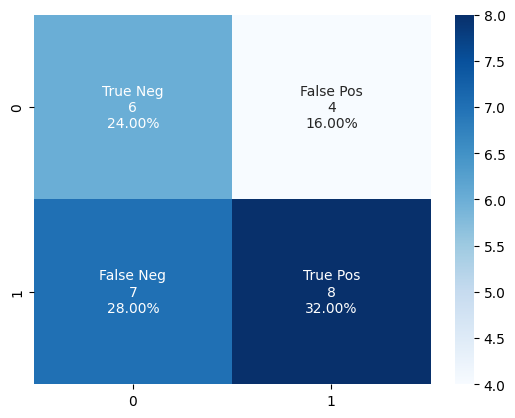

In [23]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="standard", test_size=.2, target_col="NHL")
model = MLPClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)


print_all_metrics(y_test, yhat, classifier=True)



-----MODULE CLASSIFICATION METRICS-----
precision: 0.6875
recall: 0.7333333333333333
accuracy: 0.64
f1: 0.7096774193548386


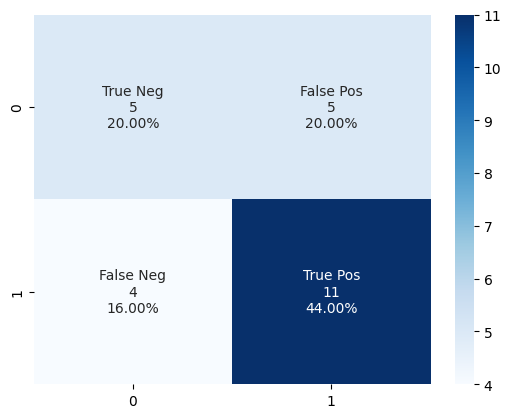

In [24]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="standard", test_size=.2, target_col="NHL")
model = SVC()

model.fit(X_train, y_train)
yhat = model.predict(X_test)


print_all_metrics(y_test, yhat, classifier=True)



-----MODULE CLASSIFICATION METRICS-----
precision: 0.5833333333333334
recall: 0.9333333333333333
accuracy: 0.56
f1: 0.7179487179487181


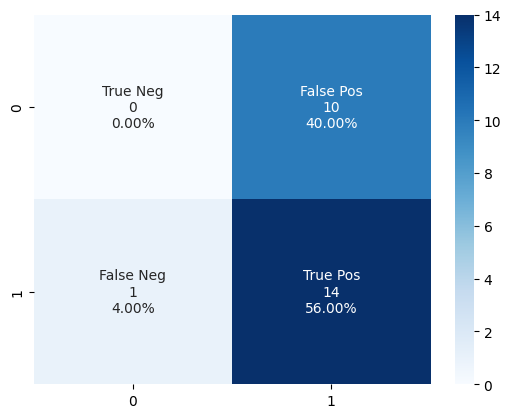

In [25]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="standard", test_size=.2, target_col="NHL")
model = GaussianNB()

model.fit(X_train, y_train)
yhat = model.predict(X_test)


print_all_metrics(y_test, yhat, classifier=True)

In [26]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="None", test_size=.3, target_col="NHL")

model = XGBClassifier(base_score=0.6, booster='gbtree', max_depth=10, n_estimators=200) 

# input matrix form for XGBoost
data_matrix = DMatrix(data=X_train, label=y_train)

model.fit(X_train, y_train)


# scores = cross_val_score(model, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

y_pred = model.predict(X_test)

 
print_all_metrics(y_test, y_pred, classifier=True)
# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

# print_all_metrics(y_test, yhat, classifier=True)

NameError: name 'scores' is not defined



-----MODULE CLASSIFICATION METRICS-----
precision: 0.7307692307692307
recall: 0.8636363636363636
accuracy: 0.7297297297297297
f1: 0.7916666666666666


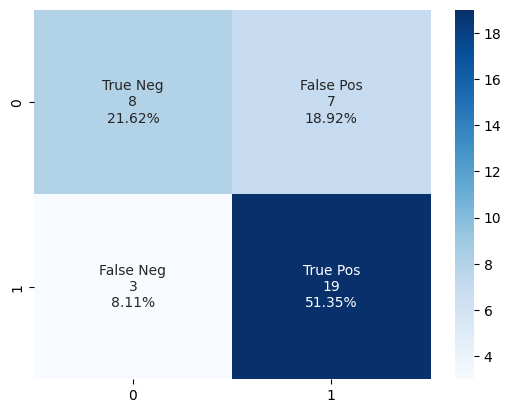

In [ ]:
X_train, X_test, y_train, y_test = scale_and_split(players_df, scaler="None", test_size=.3, target_col="NHL")

model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, )

y_pred = model.predict(X_test)
print_all_metrics(y_test, y_pred, classifier=True)


------
DF to keep track off all the results

-----
## Out of the box classifiers

### Evaluate all classifiers

In [28]:
# classifiers = [LogisticRegression(), LinearTreeClassifier(base_estimator=LogisticRegression()), DecisionTreeClassifier(), MLPClassifier(), SVC(),GaussianNB(), XGBClassifier(), CatBoostClassifier(), ]
classifiers = [LogisticRegression(), MLPClassifier(), SVC(), CatBoostClassifier()]
all_f1_results = pd.DataFrame()


In [29]:
kf = StratifiedShuffleSplit(test_size=.2, n_splits=5, random_state=0)

X, y = create_dataset(players_df)
scaler = StandardScaler()
X = scaler.fit_transform(X)

f1_scores = []
df_f1_scores = []
df_models = []
df_precisions = []
df_recalls = []
df_accuracys = []


for clf in classifiers:
    clf = clone(clf)
    indiv_f1_scores = []
    indiv_df_scores = []
    indiv_df_models = []
    indiv_df_precisions = []
    indiv_df_recalls = []
    indiv_df_accuracys = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        

        X_train = X[train_index]
        y_train = y.iloc[train_index]

        X_test= X[test_index]
        y_test = y.iloc[test_index]    


        model_name = clf.__class__.__name__
        if  model_name == "CatBoostClassifier": 
            clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
        else:
            clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        f1 = f1_score(y_test, y_pred)


        indiv_f1_scores.append(f1)
        indiv_df_precisions.append(precision_score(y_test, y_pred))
        indiv_df_recalls.append(recall_score(y_test, y_pred))
        indiv_df_accuracys.append(accuracy_score(y_test, y_pred))
    


    f1_scores.append({model_name : np.mean(indiv_f1_scores)})
    df_f1_scores.append(np.mean(indiv_f1_scores))
    df_precisions.append(np.mean(indiv_df_precisions))
    df_recalls.append(np.mean(indiv_df_recalls))
    df_models.append(model_name)
    df_accuracys.append(np.mean(indiv_df_accuracys))

results_otb = pd.DataFrame({"Model" : df_models, "Precision" : df_precisions, "Recall" : df_recalls, "Accuracy" : df_accuracys, "F1" : df_f1_scores}).set_index("Model").sort_values(by="F1", ascending=False).round(3)
all_f1_results['f1_otb'] = df_f1_scores
all_f1_results.index = df_models
all_f1_results




/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

,f1_otb
LogisticRegression,0.758652
MLPClassifier,0.685686
SVC,0.708783
CatBoostClassifier,0.713242


___

### Dealing with Class Imbalance

1. SMOTE
2. ADASyn
2. KNN OveRsampling

In [30]:
def balance_dataset(X, y, spl_type="SMOTE"):
    techniques = {
        "SMOTE" : SMOTE(random_state=0),
        "ADASYN" : ADASYN(random_state=0),
        "RANDOM" : RandomOverSampler(random_state=0),
        "KNNOR" : KNNOR(),
    }

    sampler = techniques[spl_type]


    if spl_type == "KNNOR":
        X_cols = X.columns
        y_name = y.name

        X, y, _, _ = sampler.fit_resample(X.values, y.values)
        # y = y.reshape(-1, 1)

        # because of how the library is setup have to convert back to DF/Series
        X = pd.DataFrame(X, columns=X_cols)
        y = pd.Series(y, name=y_name)
    else:
        X, y = sampler.fit_resample(X, y,)

    return X, y

In [31]:
kf = StratifiedShuffleSplit(test_size=.2, n_splits=5, random_state=0)


X, y = create_dataset(players_df, target_col="NHL")

# resample
X, y = balance_dataset(X, y, spl_type="SMOTE")

scaler = StandardScaler()
X = scaler.fit_transform(X)

f1_scores = []
df_f1_scores = []
df_models = []
df_precisions = []
df_recalls = []
df_accuracys = []

print(X.shape, y.shape)
for clf in classifiers:
    clf = clone(clf)
    indiv_f1_scores = []
    indiv_df_scores = []
    indiv_df_models = []
    indiv_df_precisions = []
    indiv_df_recalls = []
    indiv_df_accuracys = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        

        X_train = X[train_index]
        y_train = y.iloc[train_index]

        X_test= X[test_index]
        y_test = y.iloc[test_index]    


        model_name = clf.__class__.__name__
        if  model_name == "CatBoostClassifier": 
            clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
        else:
            clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        f1 = f1_score(y_test, y_pred)


        indiv_f1_scores.append(f1)
        indiv_df_precisions.append(precision_score(y_test, y_pred))
        indiv_df_recalls.append(recall_score(y_test, y_pred))
        indiv_df_accuracys.append(accuracy_score(y_test, y_pred))
    


    f1_scores.append({model_name : np.mean(indiv_f1_scores)})
    df_f1_scores.append(np.mean(indiv_f1_scores))
    df_precisions.append(np.mean(indiv_df_precisions))
    df_recalls.append(np.mean(indiv_df_recalls))
    df_models.append(model_name)
    df_accuracys.append(np.mean(indiv_df_accuracys))

results_balance = pd.DataFrame({"Model" : df_models, "Precision" : df_precisions, "Recall" : df_recalls, "Accuracy" : df_accuracys, "F1" : df_f1_scores}).set_index("Model").sort_values(by="F1", ascending=False).round(3)
all_f1_results['f1_balanced'] = df_f1_scores
all_f1_results


(148, 46) (148,)


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

,f1_otb,f1_balanced
LogisticRegression,0.758652,0.635075
MLPClassifier,0.685686,0.609570
SVC,0.708783,0.517957
CatBoostClassifier,0.713242,0.561598


Conclusion: Balancing does not seem to help the accuracy of the models at all. I do not understand the reason for this. 

--------
## Feature Selection 

### Drop correlated features using Pearson Correlation

Features that are very highly correlated with one another don't all need to be in the dataset. Too many features encourages the curse of dimensionality and so if we can be smart at reducing features, we may serve to gain model accuracy as the feature space decreases. 

<br>
Note:<br> 

- Chi square didn't work becuase values were negative

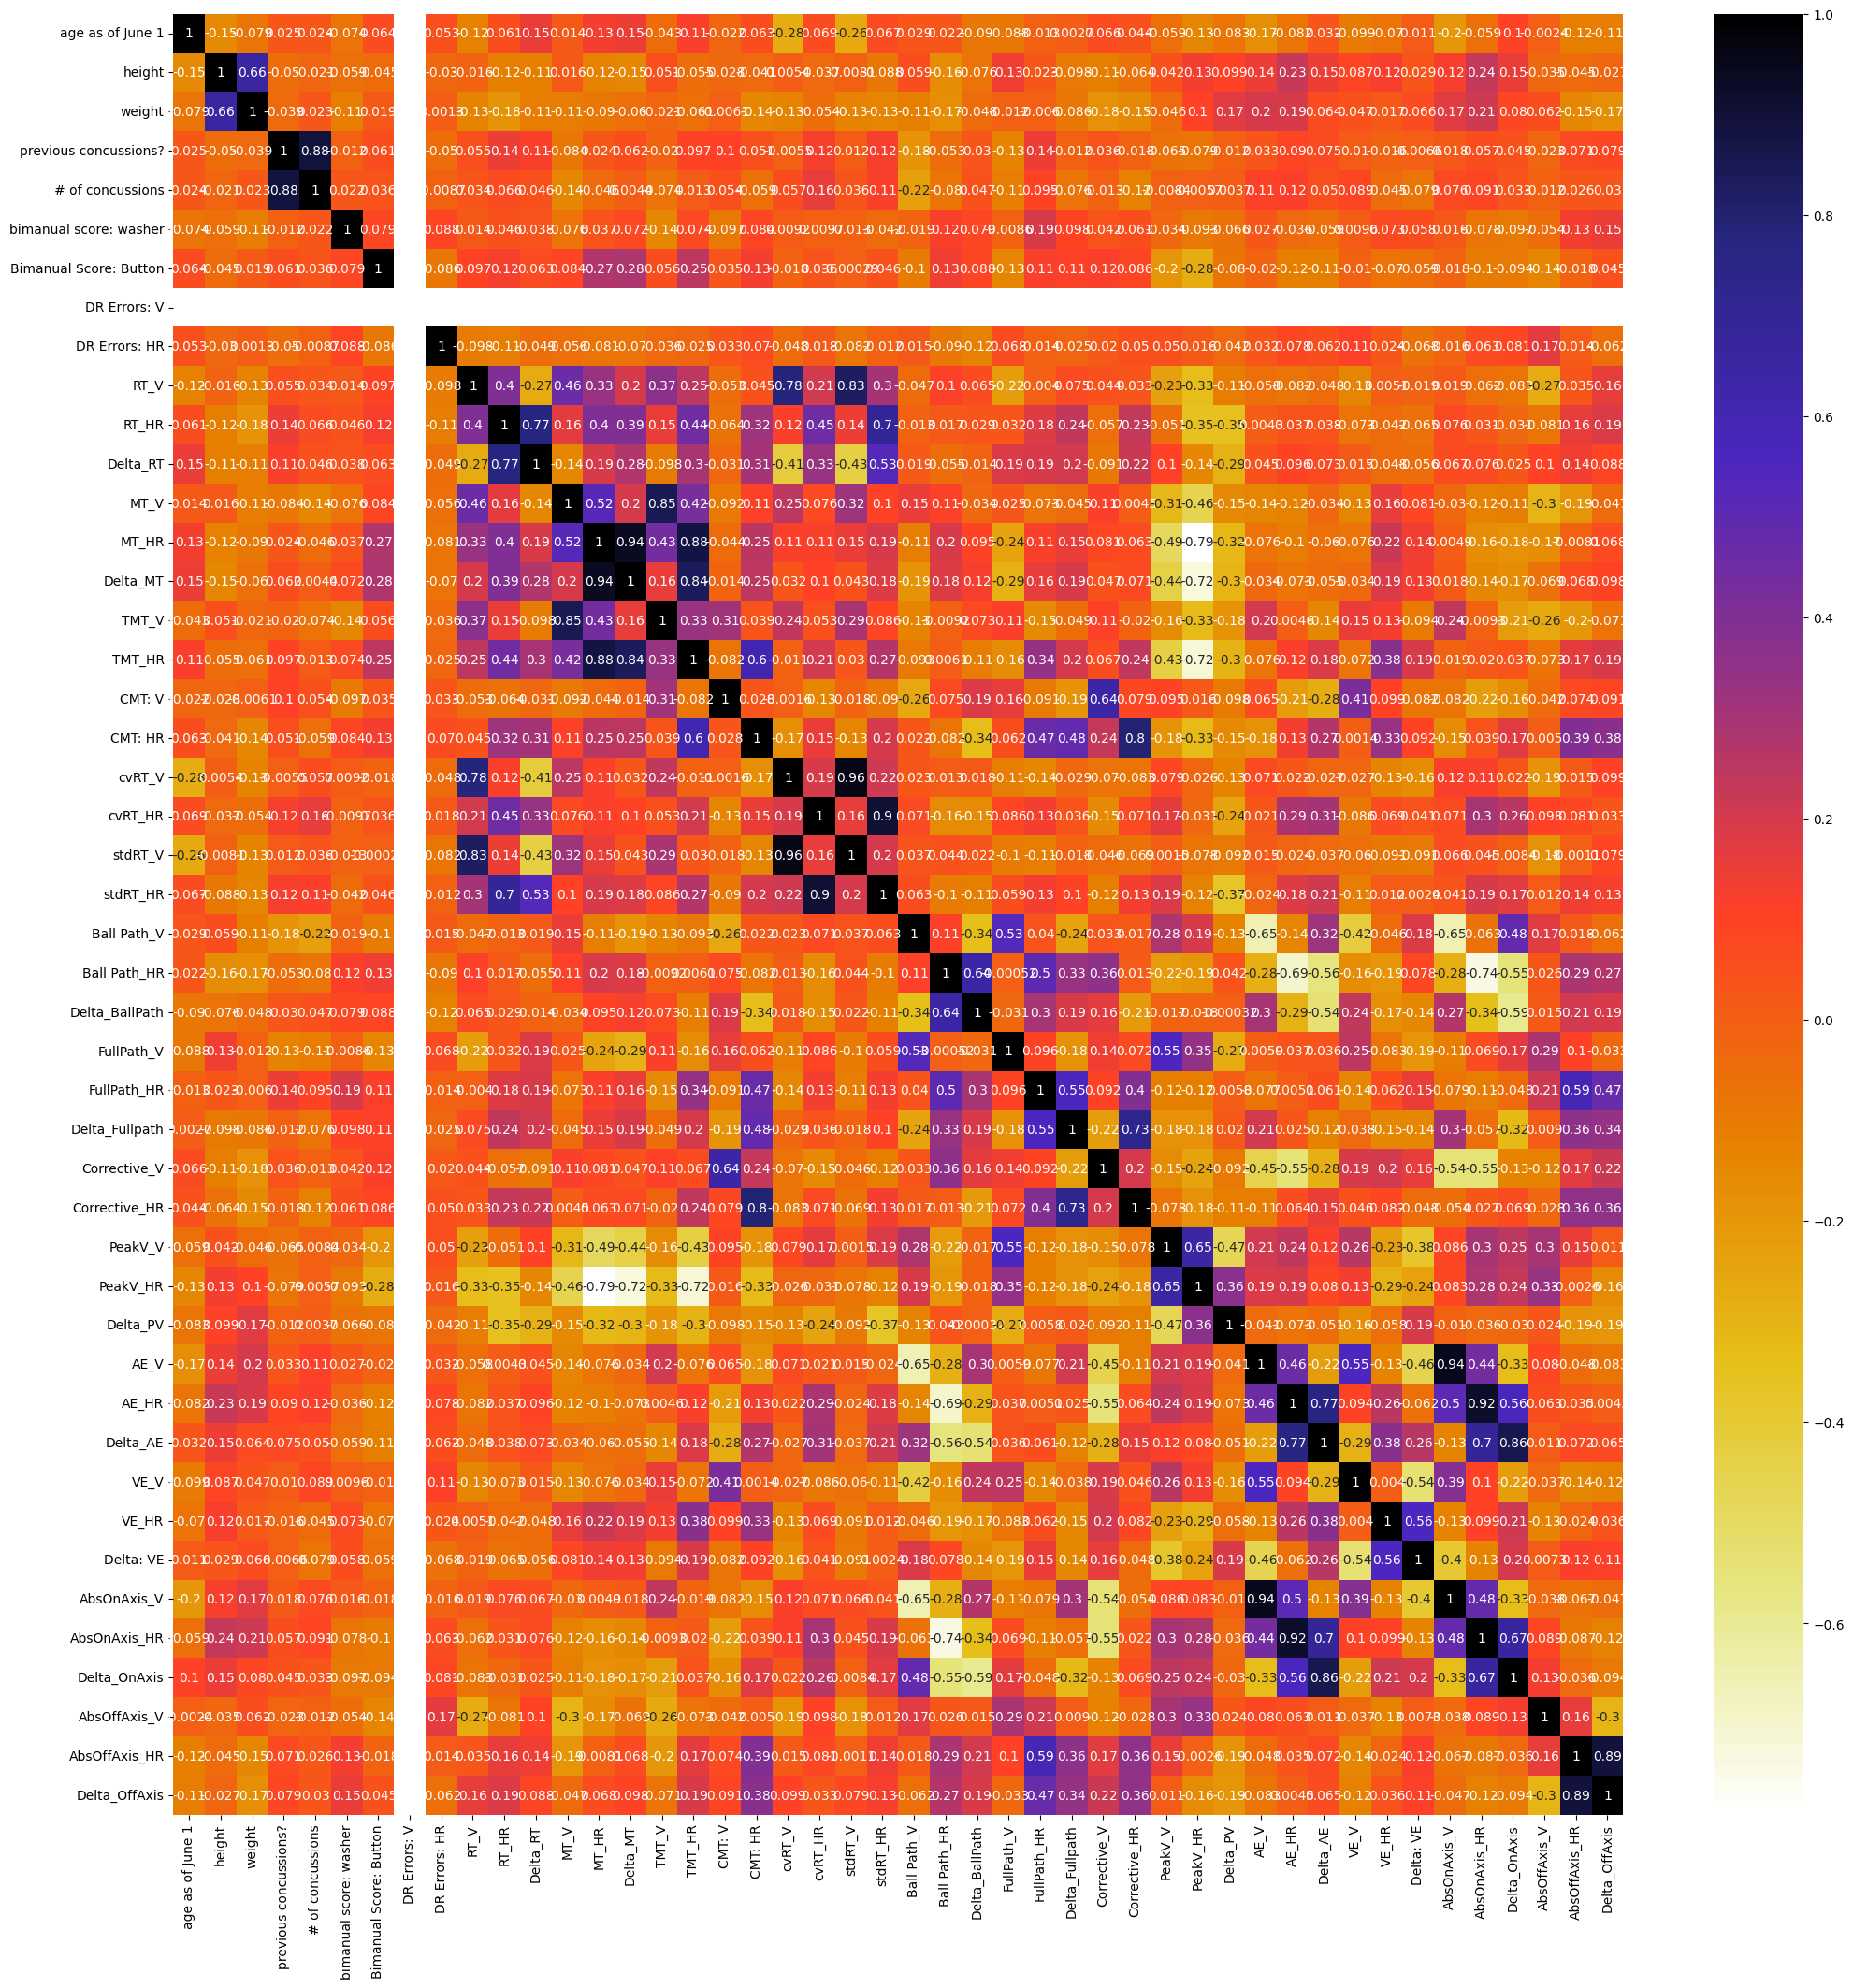

{'# of concussions',
 'AbsOnAxis_HR',
 'AbsOnAxis_V',
 'Corrective_HR',
 'Delta_AE',
 'Delta_MT',
 'Delta_OffAxis',
 'Delta_OnAxis',
 'Delta_RT',
 'PeakV_HR',
 'TMT_HR',
 'TMT_V',
 'cvRT_V',
 'stdRT_HR',
 'stdRT_V'}

In [32]:
X, y = create_dataset(players_df, target_col="NHL")
cor = pd.DataFrame(X).corr()
plt.figure(figsize=(25,25))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()  

def correlation(dataset, threshold):

    """
    Find all pairs of collumns with correllation > .7. Add one of the pairs to a set to be dropped
    """
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr  


corr_features = correlation(X, .7)
corr_features

In [33]:
kf = StratifiedShuffleSplit(test_size=.2, n_splits=5, random_state=0)

X, y = create_dataset(players_df)


# drop correlated features
corr_features = correlation(X, .7)
X.drop(corr_features, axis=1)


scaler = StandardScaler()
X = scaler.fit_transform(X)

f1_scores = []
df_f1_scores = []
df_models = []
df_precisions = []
df_recalls = []
df_accuracys = []

print(X.shape, y.shape)
for clf in classifiers:
    clf = clone(clf)
    indiv_f1_scores = []
    indiv_df_scores = []
    indiv_df_models = []
    indiv_df_precisions = []
    indiv_df_recalls = []
    indiv_df_accuracys = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        

        X_train = X[train_index]
        y_train = y.iloc[train_index]

        X_test= X[test_index]
        y_test = y.iloc[test_index]    


        model_name = clf.__class__.__name__
        if  model_name == "CatBoostClassifier": 
            clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
        else:
            clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        f1 = f1_score(y_test, y_pred)


        indiv_f1_scores.append(f1)
        indiv_df_precisions.append(precision_score(y_test, y_pred))
        indiv_df_recalls.append(recall_score(y_test, y_pred))
        indiv_df_accuracys.append(accuracy_score(y_test, y_pred))
    


    f1_scores.append({model_name : np.mean(indiv_f1_scores)})
    df_f1_scores.append(np.mean(indiv_f1_scores))
    df_precisions.append(np.mean(indiv_df_precisions))
    df_recalls.append(np.mean(indiv_df_recalls))
    df_models.append(model_name)
    df_accuracys.append(np.mean(indiv_df_accuracys))

results_feat_sel = pd.DataFrame({"Model" : df_models, "Precision" : df_precisions, "Recall" : df_recalls, "Accuracy" : df_accuracys, "F1" : df_f1_scores}).set_index("Model").sort_values(by="F1", ascending=False).round(3)
all_f1_results['f1_rm_corr_features'] = df_f1_scores
all_f1_results


(123, 46) (123,)


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

,f1_otb,f1_balanced,f1_rm_corr_features
LogisticRegression,0.758652,0.635075,0.758652
MLPClassifier,0.685686,0.609570,0.681043
SVC,0.708783,0.517957,0.708783
CatBoostClassifier,0.713242,0.561598,0.713242


## Ranking Columns based on ${Chi}^2$

In [65]:
f_p_values=chi2(X,y)
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
p_values = p_values.sort_index(ascending=False)
p_values

ValueError: Input X must be non-negative.

## Keeping only the top N=8 features using extra tree classifier

Notes: <br>

* Trains differently every time and I am not sure why. Might be because of the ExtraTreesclassifier although that should be seeded

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
def get_n_important_features(X, y, n_features=10):
    model = ExtraTreesClassifier(random_state=0)
    model.fit(X, y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns).nlargest(n_features)
    
    top_n_columns=feat_importances.keys().to_list()

    top_n_features = pd.DataFrame({'importance' : feat_importances}, index=top_n_columns).sort_values(by="importance", ascending=False)
    return top_n_features




In [35]:
kf = StratifiedShuffleSplit(test_size=.2, n_splits=5, random_state=0)

X, y = create_dataset(players_df)

important_features = get_n_important_features(X, y, 10)

# drop all but 10 most important features
X = X.drop(list(set(X.columns) - set(important_features.index)), axis=1)
print(X.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)

f1_scores = []
df_f1_scores = []
df_models = []
df_precisions = []
df_recalls = []
df_accuracys = []

for clf in classifiers:
    clf = clone(clf)
    indiv_f1_scores = []
    indiv_df_scores = []
    indiv_df_models = []
    indiv_df_precisions = []
    indiv_df_recalls = []
    indiv_df_accuracys = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        

        X_train = X[train_index]
        y_train = y.iloc[train_index]

        X_test= X[test_index]
        y_test = y.iloc[test_index]    


        model_name = clf.__class__.__name__
        if  model_name == "CatBoostClassifier": 
            clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
        else:
            clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        f1 = f1_score(y_test, y_pred)


        indiv_f1_scores.append(f1)
        indiv_df_precisions.append(precision_score(y_test, y_pred))
        indiv_df_recalls.append(recall_score(y_test, y_pred))
        indiv_df_accuracys.append(accuracy_score(y_test, y_pred))
    


    f1_scores.append({model_name : np.mean(indiv_f1_scores)})
    df_f1_scores.append(np.mean(indiv_f1_scores))
    df_precisions.append(np.mean(indiv_df_precisions))
    df_recalls.append(np.mean(indiv_df_recalls))
    df_models.append(model_name)
    df_accuracys.append(np.mean(indiv_df_accuracys))

results_feat_sel = pd.DataFrame({"Model" : df_models, "Precision" : df_precisions, "Recall" : df_recalls, "Accuracy" : df_accuracys, "F1" : df_f1_scores}).set_index("Model").sort_values(by="F1", ascending=False).round(3)
all_f1_results['f1_top_n_features'] = df_f1_scores
all_f1_results


Index(['DR Errors: HR', 'MT_HR', 'Delta_MT', 'TMT_V', 'cvRT_HR',
       'Ball Path_HR', 'Delta_BallPath', 'PeakV_HR', 'Delta: VE',
       'AbsOnAxis_HR'],
      dtype='object')


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

,f1_otb,f1_balanced,f1_rm_corr_features,f1_top_n_features
LogisticRegression,0.758652,0.635075,0.758652,0.731169
MLPClassifier,0.685686,0.609570,0.681043,0.697446
SVC,0.708783,0.517957,0.708783,0.745841
CatBoostClassifier,0.713242,0.561598,0.713242,0.747527


-----
Feature selection via Forward selection.

This was used in the SOA draft by the numbers and is a brute force technique for feature selection

In [38]:
def feature_num_to_name(indicies, df):
    cols = df.columns
    return list(map(lambda i: cols[i], indicies))

feature_num_to_name([0, 3, 4, 7, 8, 9, 11, 30], X_train)

['year',
 'height',
 'weight',
 'draft number',
 'drafted',
 'shoots',
 'previous concussions?',
 'stdRT_HR']

In [64]:
import json

def do_sequential_selection(estimator, df):

    X, y = create_dataset(df)
    # print(X.columns)

    X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)
                                                    
    sfs1 = SequentialFeatureSelector(estimator=estimator, 
            k_features=(7, 12),
            forward=True, 
            floating=False, 
            scoring='f1',
            cv=5)

    pipe = make_pipeline(StandardScaler(), sfs1)

    pipe.fit(X_train, y_train,)

    print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, feature_num_to_name(sfs1.k_feature_idx_, X_train)), end="\n\n")
    print('all subsets:\n', sfs1.subsets_)
    plot_sfs(sfs1.get_metric_dict(), kind='std_err')

    return sfs1

sfs1 = do_sequential_selection(estimator=XGBClassifier(), df=players_df)

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [55]:
sfs1.subsets_

{1: {'feature_idx': (11,),
  'cv_scores': array([0.75      , 0.7826087 , 0.72727273, 0.85714286, 0.66666667]),
  'avg_score': 0.756738189346885,
  'feature_names': ('11',)},
 2: {'feature_idx': (9, 11),
  'cv_scores': array([0.76923077, 0.8       , 0.73684211, 0.85714286, 0.69565217]),
  'avg_score': 0.7717735811099655,
  'feature_names': ('9', '11')},
 3: {'feature_idx': (7, 9, 11),
  'cv_scores': array([0.76923077, 0.8       , 0.73684211, 0.85714286, 0.69565217]),
  'avg_score': 0.7717735811099655,
  'feature_names': ('7', '9', '11')},
 4: {'feature_idx': (0, 7, 9, 11),
  'cv_scores': array([0.76923077, 0.8       , 0.7       , 0.85714286, 0.72727273]),
  'avg_score': 0.7707292707292707,
  'feature_names': ('0', '7', '9', '11')},
 5: {'feature_idx': (0, 4, 7, 9, 11),
  'cv_scores': array([0.66666667, 0.7826087 , 0.7       , 0.9       , 0.7826087 ]),
  'avg_score': 0.7663768115942029,
  'feature_names': ('0', '4', '7', '9', '11')},
 6: {'feature_idx': (0, 3, 4, 7, 9, 11),
  'cv_scores'

In [53]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)



json.dumps(sfs1.subsets_, )

TypeError: Object of type ndarray is not JSON serializable